In [1]:
import torch
from torch import nn
from torchviz import make_dot, make_dot_from_trace
import torch.nn.functional as F
import torch.autograd as autograd

import torchvision
import hiddenlayer as hl

In [2]:
import torch
from torch import nn
import Config
import pandas as pd
import numpy as np

def embeddings_helper(window_size):
    vocab_set = set()

    def generate_vocab_helper(set, k): 
        n = len(set)  
        generate_vocab(set, "", n, k) 

    def generate_vocab(set, prefix, n, k): 
        if (k == 0) : 
            vocab_set.add(prefix)
            return
        for i in range(n): 
            newPrefix = prefix + set[i] 
            generate_vocab(set, newPrefix, n, k - 1) 

    def generate_embed_map(n):
        alphabet = ['0','1','2','3','4']
        generate_vocab_helper(alphabet, n)

        vocab_set_1 = sorted(vocab_set)
        vocab_map = {}

        for i in range(len(vocab_set_1)):
            vocab_map[vocab_set_1[i]] = i
        return vocab_map
    return generate_embed_map(window_size)

#ATG, GTG, TTG
def is_start_codon(codon):
    start_codons = ['143', '343', '443']#['ATG', 'GTG', 'TTG']
    if codon in start_codons:
        return True
    return False

def create_vocabulary(window_size):
    print("len: ", len(embeddings_helper(window_size)))
    return embeddings_helper(window_size)

In [3]:
class Lstm_Net(nn.Module):
    def __init__(self, sent_size):
        super(Lstm_Net, self).__init__()
        self.sent_size = 99
        self.embeds = nn.Embedding(len(create_vocabulary(3)), 5)
        self.embeds_size = 5 * 99
        self.lstm = nn.LSTM(self.embeds_size, 99, 2)
        self.fc1 = nn.Linear(99, 99)
        self.dropout1 = nn.Dropout(0.1)
        self.relu = F.relu
        self.fc2 = nn.Linear(99, 1)
        self.dropout2 = nn.Dropout(0.1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inputs):
        print("shape", inputs.shape)
        embedding_weights = self.embeds(inputs).view((-1, self.embeds_size))
        embedding_weights = inputs
        embedding_weights.unsqueeze_(0)
        embedding_weights = embedding_weights.expand(1, -1, -1)
        print("embed weights", embedding_weights.shape)
        embedding_weights = embedding_weights.type(torch.FloatTensor)
        lstm_output, (last_hidden_state, last_cell_state) = self.lstm(embedding_weights)
        layer1 = self.fc1(lstm_output[-1])
        # layer1 = self.fc1(embedding_weights)
        layer1 = self.dropout1(layer1)
        act1 = self.relu(layer1)
        layer2 = self.fc2(act1)
        layer2 = self.dropout2(layer2)
        # act2 = self.relu(layer2)
        output = self.sigmoid(layer2)
        return output

len:  125
shape torch.Size([100, 495])
embed weights torch.Size([1, 100, 495])


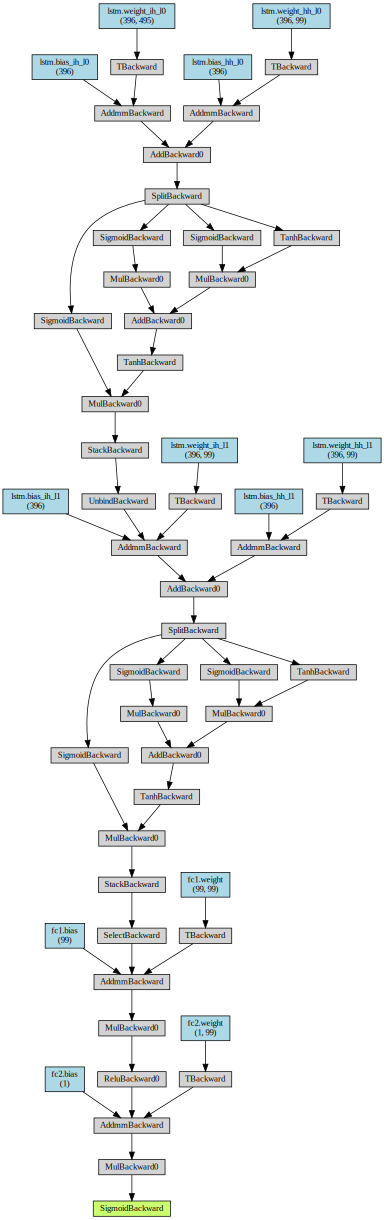

In [4]:
model = Lstm_Net(99)
x = torch.LongTensor(100, 495)
make_dot(model(x), params=dict(model.named_parameters()))

len:  125
shape torch.Size([100, 495])
embed weights torch.Size([1, 100, 495])


/Users/siddarth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  app.launch_new_instance()
/Users/siddarth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!


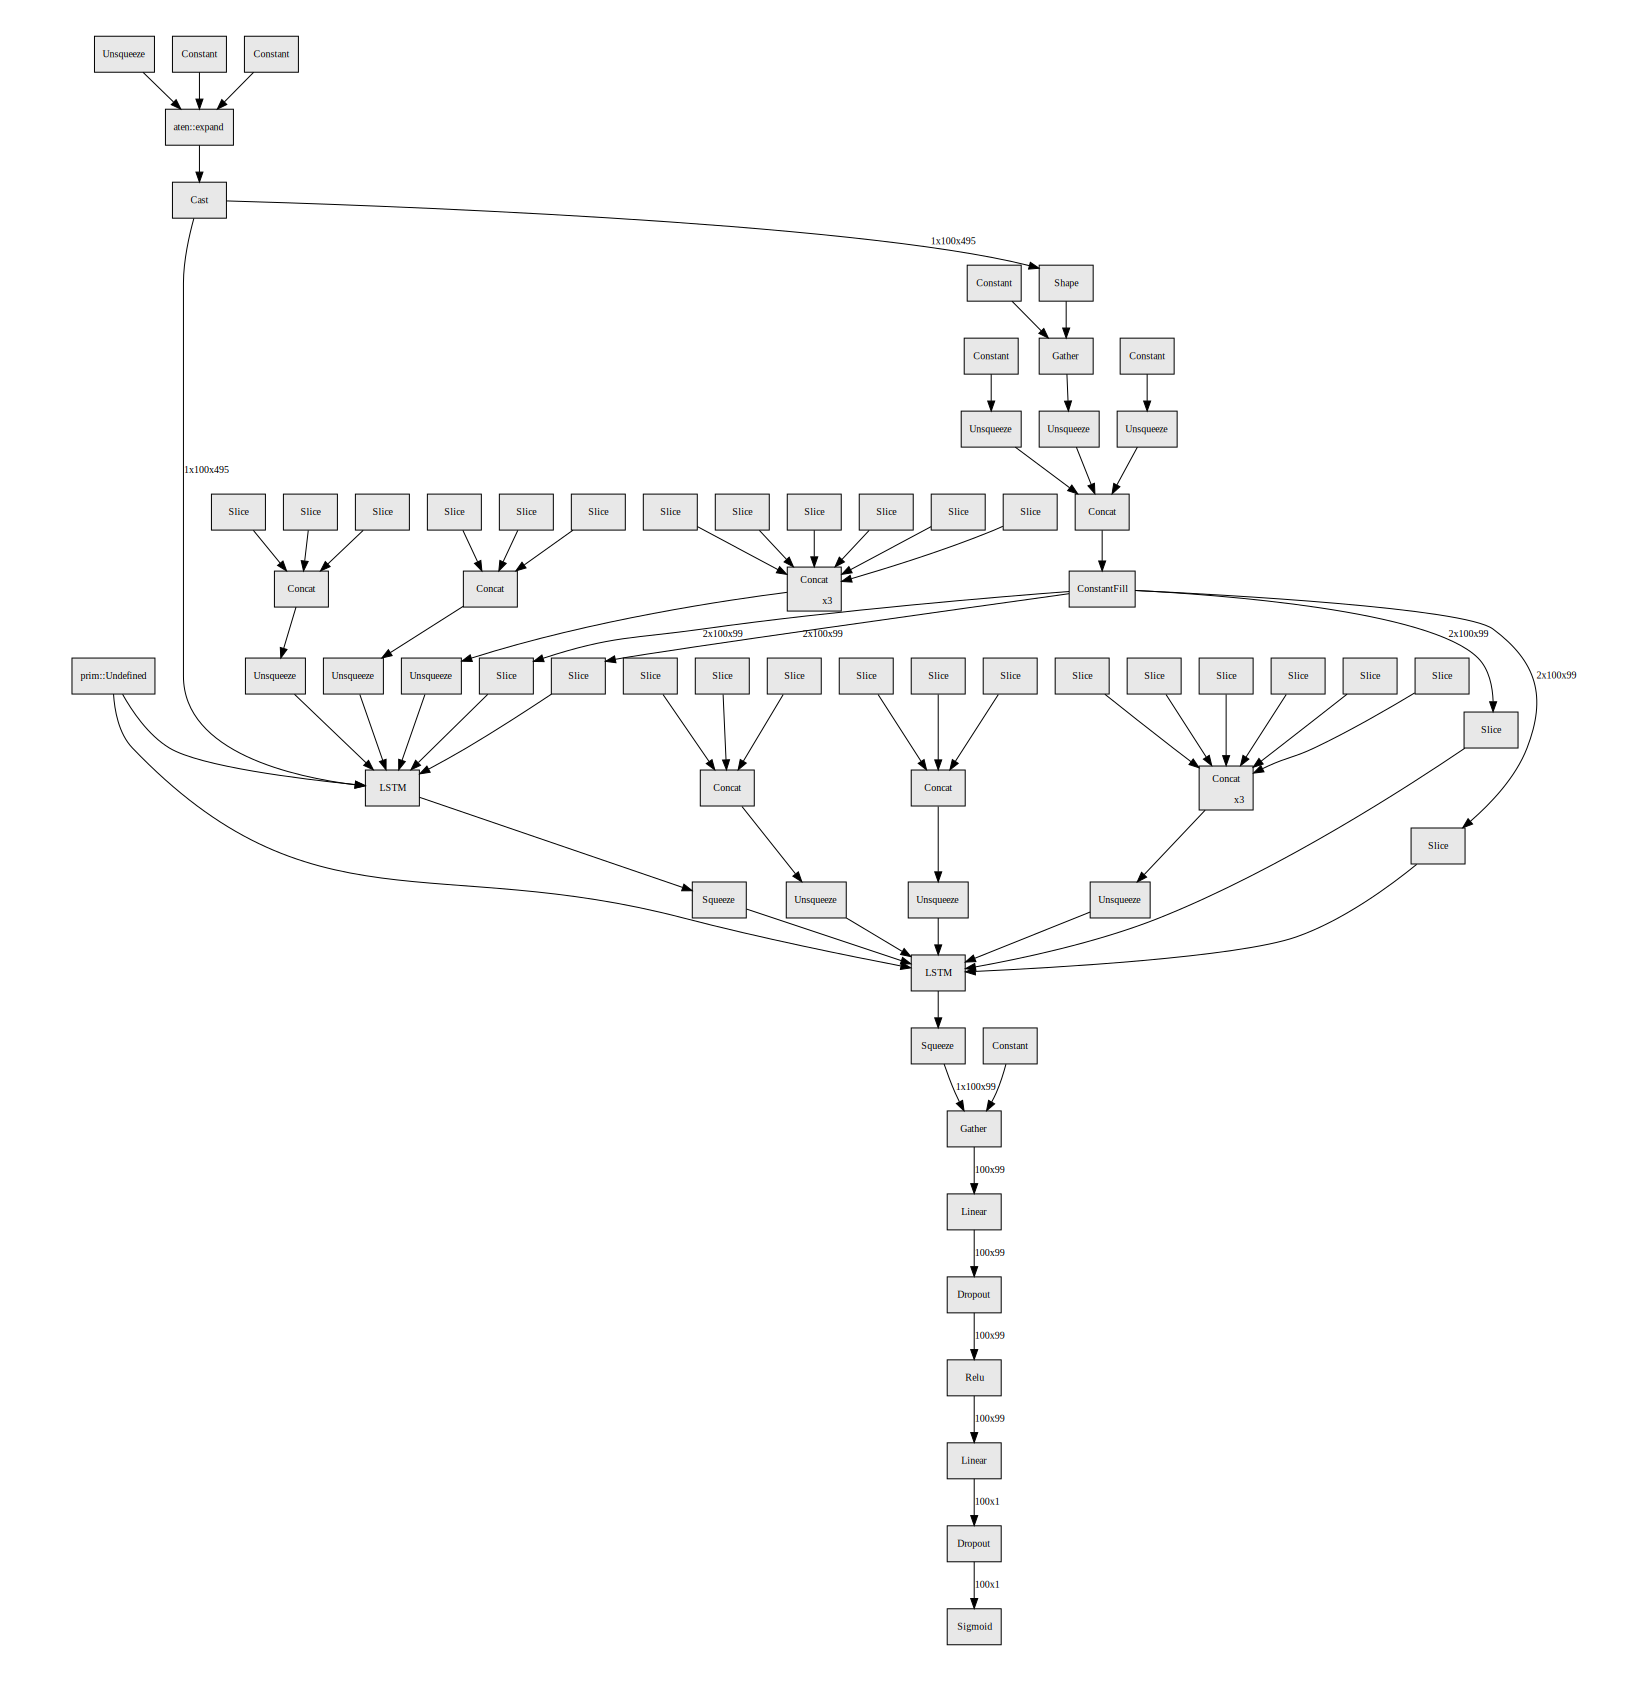

In [5]:
# VGG16 with BatchNorm
model = Lstm_Net(99)
x = torch.LongTensor(100, 495)
hl.build_graph(model, x)